# Linear Regression

**시작전에!**

* 코랩(Colab) 이용자 분들은
메뉴 → 런타임(Runtime) → 런타임 유형변경(Change runtime type) → 런타임 버전 2025.07 → 저장(save)

* 로컬 이용자 분들은 conda 환경 python 버전을 3.11.13로 사용하시면 됩니다.

을 해주셔야 오류없이 d2l이 설치 됩니다.

In [1]:
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 139.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 99.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Succe

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Defining the Model

- Initialize weights by drawing random numbers from a normal distribution with mean 0 and a standard deviation of 0.01
- set bias 0

In [2]:
class LinearRegressionScratch(d2l.Module):
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

- weight **w**, input features **X**, bias **b**(scalar)

In [3]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
    # X: (B, D) # self.w: (D, 1)
    # torch.matmul(self.w, X)이 아니라 torch.matmul(X, self.w)을 해야
    # (B, D) * (D, 1)의 행렬곱이 제대로 이루어져서 (B, 1)을 output함
    return torch.matmul(X, self.w) + self.b


## Defining the Loss Function

- transform true value y into the predicted value's shape y_hat
- averaged loss value를 최종결과로 return

In [4]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
  # y_hat: (N, 1), y: (N)일 수도, (N, 1)일 수도
  # y의 shape의 y_hat으로 맞춰줘야 안전하게 연산 가능
  y = y.reshape(y_hat.shape)
  l = (y_hat - y) ** 2
  return l.mean()

## Defining the Optimization Algorithm

과제는 아니지만, 전체적인 deep learning pipeline을 파악해주세요!

In [5]:
class SGD(d2l.HyperParameters):
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [6]:
@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

##Training

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$


In [7]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

loss를 확인해봅시다 !

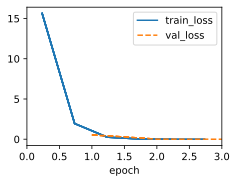

In [8]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

# 정답 그림과 내 Loss line graph가 다른 건 상관이 없나?
  # 예상: batch가 random하게 구성되기 때문에 다르게 나타났을 것 같음
  # 그래서 상관 없을듯

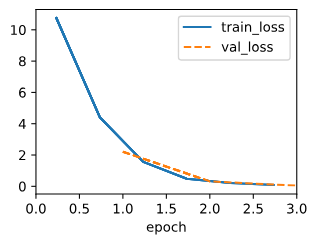

-정답 그림

# Softmax Regression

다양한 X를 설정해서 진행해주셔도 좋을 거 같습니다 :>

In [11]:
X = torch.tensor([[0.0, -2.0, 3.0], [1.4, 2.0, 5.3]])
X.sum(0, keepdims=False), X.sum(1, keepdim=False)
  # keepdim이 왜 중요하고 # 여기서 이걸 왜 확인하는 거지??
    # softmax로 X를 확률값으로 변환할 때 (나눗셈 시) X의 shape을 유지하기 위해서

(tensor([1.4000, 0.0000, 8.3000]), tensor([1.0000, 8.7000]))

(**
$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$
**)

softmax를 구현해주세요

In [12]:
def softmax(X):
    X_exp = torch.exp(X)
    prob = X_exp / X_exp.sum(1, keepdim=True)
    return prob

In [13]:
X = torch.rand((2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1756, 0.2181, 0.2682, 0.2149, 0.1232],
         [0.2067, 0.1928, 0.2839, 0.1382, 0.1785]]),
 tensor([1., 1.]))

## Model

- 28*28 pixel image를 가지고, flatten하여 vector로 만듦
- 10 class 존재

In [14]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

In [17]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0])) # 가중치의 dimension에 맞춰서 28x28 pixel을 핌
    return softmax(torch.matmul(X, self.W) + self.b)

## Cross-Entropy Loss

다양한 y로 연습해보셔도 좋을 거 같습니다 :>

In [16]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

Cross entropy loss를 구현해주세요

In [18]:
def cross_entropy(y_hat, y):
    loss = -torch.log(y_hat[range(len(y_hat)), y])
    # y_hat의 길이에 따라 다르게 처리
    # 각 sample에 대해서 # 정답 label(y에 integer index로 있음)의 값을 가져오기
      # 원래 cross entropy 식은
        # 예측 로그 확률값에 대해 실제 정답을 곱한 수 sum -> negative 취해주는 형태고
        #'진짜' 정답 확률은 [[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]] 이겠지만
        # 어차피 오답인 값은 0 돼서 의미 없어짐
        # 정답인 label의 예측 확률값만 update에 쓰기 때문에 상관 없음
    return loss.mean()

cross_entropy(y_hat, y)

tensor(1.4979)

In [19]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

## Training

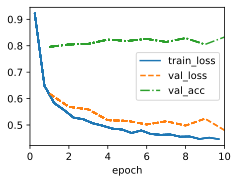

In [21]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=28*28, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

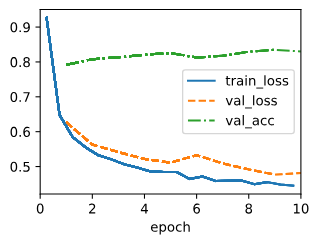
-정답 그림

## Prediction

어떤 방식으로 prediction 및 사진이 나오는지 확인해주세요

In [22]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape #(B, 1)로 최종 classification 결과 나옴

torch.Size([256])

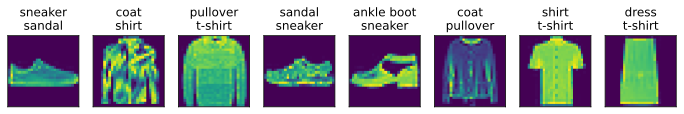

In [23]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)